```
Copyright (c) 2024-2025 National Institute of Advanced Industrial Science and Technology (AIST)
All rights reserved.
This software is released under the MIT License.
http://opensource.org/licenses/mit-license.php
```

## Introduction
In this notebook, you will learn the basic usage of the ef_crafter.
1. [Sending frames without repeats](#1.-Sending-frames-without-repeats)
   1. [Connect to the device using xsdb](#1-A.-Open-xsdb-device-to-access-TSN-EFCC)
   2. [Set the internal switch](#1-B.-Configure-the-internal-switch)
   3. [Set up the ef_crafter](#1-C.-Set-up-the-ef_crafter)
   4. [Prepare send frames](#1-D.-Prepare-send-frames)
   5. [Send the frames](#1-E.-Send-the-frames)
   6. [Wait for transmission to complete](#1-F.-Wait-for-transmission-to-complete)
   7. [(Optional) Verify frames sent with WireShark](#1-F.-(Optional)-Verify-frames-sent-with-WireShark)
2. [Sending frames with repeats](#2-A.-Running-the-frame-crafter-with-repeat-enabled)
   1. [Running the frame crafter with repeat enabled](#2-A.-Running-the-frame-crafter-with-repeat-enabled)
   2. [Wait for the specified number of frames to be transmitted](#2-B.-Wait-for-the-specified-number-of-frames-to-be-transmitted)
   3. [Stop the frame crafter](#2-C.-Stop-the-frame-crafter)
3. [Control of the transmission rate of the frame crafter](#3.-Control-of-the-transmission-rate-of-the-frame-crafter)
   1. [Transmission of frames at minimum frame intervals](#3-A.-Transmission-of-frames-at-minimum-frame-intervals)
   2. [Transmission of frames using await](#3-B.-Transmission-of-frames-using-await)
   3. [Transmission of frames with NOP frames in between](#3-C.-Transmission-of-frames-with-NOP-frames-in-between)

In [1]:
import argparse
import tsn_efcc
import pyxsdb
from IPython.display import Image, display

No equipment other than the TSN-EFCC is required for this notebook.
However, by connecting MAC3 (Port3) to the host PC's NIC as shown below, you can use WireShark to check the content and output rate of the frames generated by the ef_crafter.


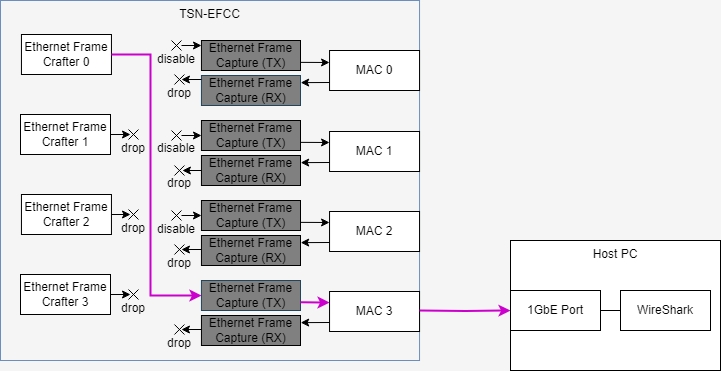

In [2]:
print('No equipment other than the TSN-EFCC is required for this notebook.')
print("However, by connecting MAC3 (Port3) to the host PC's NIC as shown below, you can use WireShark to check the content and output rate of the frames generated by the ef_crafter.")
display(Image(filename='img/overwiew_sample_design-1g_example_configuration1.drawio.png', embed=True))

## 1. Sending frames without repeats

### 1-A. Open xsdb device to access TSN-EFCC

In [3]:
xsdb = pyxsdb.PyXsdb()
xsdb.connect()

xsdb server launched.


'tcfchan#0'

Dump xsdb targets

In [4]:
print(xsdb.target())

1  xc7k325t
     2  Legacy Debug Hub
        3  JTAG2AXI
  4  xc7k325t
     5  Legacy Debug Hub
        6  JTAG2AXI
  7  APU
     8  ARM Cortex-A9 MPCore #0 (Running)
     9  ARM Cortex-A9 MPCore #1 (Running)
 10  xc7z020
    11  Legacy Debug Hub
       12  JTAG2AXI


Set JTAG2AXI target. As default, this target is expected to be target 3.
If you want to different target value, change the next value.

In [5]:
xsdb_target = 3
xsdb.target(xsdb_target)

''

After calling xsdb.target(), the current target is marked in the following log.

In [6]:
print(xsdb.target())

1  xc7k325t
     2  Legacy Debug Hub
        3* JTAG2AXI
  4  xc7k325t
     5  Legacy Debug Hub
        6  JTAG2AXI
  7  APU
     8  ARM Cortex-A9 MPCore #0 (Running)
     9  ARM Cortex-A9 MPCore #1 (Running)
 10  xc7z020
    11  Legacy Debug Hub
       12  JTAG2AXI


### 1-B. Configure the internal switch

Get the default address table object.

In [7]:
default_addr_table = tsn_efcc.default_tsn_efcc_address_table()
print(f'{default_addr_table}\n')

TsnEfccAddressTable(ef_crafter=1593835520, ef_crafter_buffers=(1342177280, 1358954496, 1375731712, 1392508928), ef_crafter_ip_tables=(1409286144, 1426063360, 1442840576, 1459617792), ef_crafter_mac_tables=(1476395008, 1493172224, 1509949440, 1526726656), ef_capture_tx_ctrl=(1325400064, 1325465600, 1325531136, 1325596672), ef_capture_rx_ctrl=(1325662208, 1325727744, 1325793280, 1325858816), ef_capture_buffers=(1073741824, 1090519040, 1107296256, 1124073472), ef_capture_buffer_switch=(1326448640, 1326514176, 1326579712, 1326645248), axis_net_switch=1610612736, commit_hash=1048576)



Initialize AxisNetSwitch object.

In [8]:
switch = tsn_efcc.AxisNetSwitch(xsdb, xsdb_target, default_addr_table)

This object can control the connection between input port and output port.  
In this test, we connect EFcrafter0(port 4) to TX3(port 3).  
Other input ports are disconnected from output port.

In [9]:
switch.start_config()
switch.connect(4, 3)   # ef_crafter 0 -> MAC 3 TX
switch.commit()

Configuration is done. show current switch status.

In [10]:
switch.show_configuration()

input MAC0-RX -> Drop
input MAC1-RX -> Drop
input MAC2-RX -> Drop
input MAC3-RX -> Drop
input EFCrafter0 -> MAC3-TX
input EFCrafter1 -> Drop
input EFCrafter2 -> Drop
input EFCrafter3 -> Drop


### 1-C. Set up the ef_crafter
Initialize EFCrafter object.

In [11]:
crafter = tsn_efcc.EFCrafter(xsdb, xsdb_target, default_addr_table)

Show what MAC/IP value is set to the transmit frame.  
In 1-D code, we set ether(dst=2, src=1).ipv4(dst=2, src=1), these values are the index of LUT table.  
By using crafter.get_mac_address(port, index) or get_ip_address(port, index) function, you can show this value.

In [12]:
mac1 = crafter.get_mac_address(port=0, index=1)
mac2 = crafter.get_mac_address(port=0, index=2)
ip1 = crafter.get_ip_address(port=0, index=1)
ip2 = crafter.get_ip_address(port=0, index=2)
print(f'Read done. ether(dst=2, src=1).ipv4(dst=2, src=1) means ether(dst={mac2}, src={mac1}).ipv4(dst={ip2}, src={ip1})')

Read done. ether(dst=2, src=1).ipv4(dst=2, src=1) means ether(dst=00:1b:21:ee:a4:ef, src=00:1b:21:ee:a5:0c).ipv4(dst=192.168.0.2, src=192.168.0.1)


### 1-D. Prepare send frames
Frame class is a helper class to create the frame information sent by ef_crafter.  
Firstly, we create a frame information which flows Port0 -> Port1.


In [13]:
frame0 = tsn_efcc.Frame('Frame0').ether(dst=2, src=1).ipv4(dst=2, src=1).udp(dst=1000, src=2000).payload(length=1024)
print(f'Format of frame0: {frame0}\n')

Format of frame0: Frame0.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=1024)



Next, send frame0 frame from EFCrafter0.  
Push the frame object to ef_crafter. The last frame must be a special frame named EOL frame.

In [14]:
eol_frame = tsn_efcc.Frame.eol()
crafter.set_frame(port=0, index=0, frame=frame0)
crafter.set_frame(port=0, index=1, frame=eol_frame)

Dump the frame information pushed to ef_crafter.

In [15]:
for frame in crafter.get_frames(port=0):
    print(frame)

Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=1024)
EOL()


### 1-E. Send the frames

Show the initial status of ef_crafter port 0.

In [16]:
for k, v in crafter.get_status(0).items():
    print(f'{k}: {v}')

status: Stopped
repeat: disable
loopcounter: 0
framecounter: 0
com_running: False
com_repeat: False
com_fno_reset: False
sta_send_done: True
sta_repeat_done: True
sta_counter_reset_done: True


Then send frames.

In [17]:
port = 0
bit_mask = 1 << port
crafter.reset(bit_mask)
crafter.start(bit_mask)

### 1-F. Wait for transmission to complete

In [18]:
crafter.wait(port)

Transfer done. After transfer, framecounter value must be increased to 2 (1 frame + 1 EOL frame). Current status is

In [19]:
print('-------')
print('Port0:')
for k, v in crafter.get_status(0).items():
    print(f'  {k}: {v}')
print('-------')

-------
Port0:
  status: Stopped
  repeat: disable
  loopcounter: 0
  framecounter: 1
  com_running: False
  com_repeat: False
  com_fno_reset: False
  sta_send_done: True
  sta_repeat_done: True
  sta_counter_reset_done: True
-------


### 1-F. (Optional) Verify frames sent with WireShark
If you run WireShark before running crafter.start(), you can confirm that a frame like the following is received.  
You can check the IP address, MAC address, protocol, frame size, etc. that you specified when you registered the frame in [1-C.-Set-up-the-ef_crafter](#1-C.-Set-up-the-ef_crafter).  
You can also see that the magic word `TSNefcc` is embedded at the beginning of the payload and that the rest of the payload is padded with zeros.

### frame0

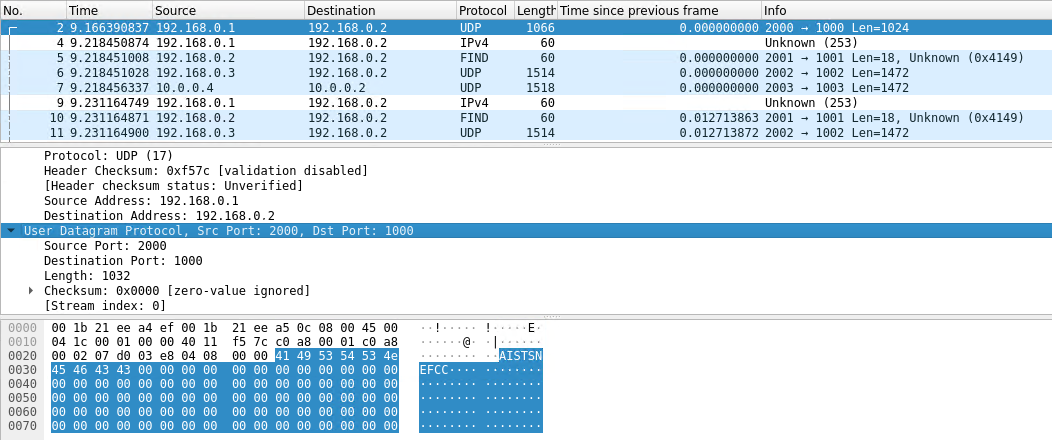

In [20]:
display(Image(filename='img/1_wireshark_frameinfo.png', embed=True))

Let's generate several frames with different content and check them with WireShark.

In [21]:
# Prepare different types of frames
# Smallest frame size without protocol header
frame1 = tsn_efcc.Frame('Frame0').ether(dst=2, src=1).ipv4(dst=2, src=1).payload(length=26)
# Smallest UDP frame
frame2 = tsn_efcc.Frame('Frame0').ether(dst=2, src=2).ipv4(dst=2, src=2).udp(dst=1001, src=2001).payload(length=18)
# Largest UDP frame
frame3 = tsn_efcc.Frame('Frame0').ether(dst=2, src=3).ipv4(dst=2, src=3).udp(dst=1002, src=2002).payload(length=1472)
# Largest UDP frame with VLAN TAG
frame4 = tsn_efcc.Frame('Frame0').ether(dst=2, src=4).vlan(vlan_id=1, pcp=2).ipv4(dst=7, src=9).udp(dst=1003, src=2003).payload(length=1472)

# Registering these frames
crafter.set_frame(port=0, index=0, frame=frame1)
crafter.set_frame(port=0, index=1, frame=frame2)
crafter.set_frame(port=0, index=2, frame=frame3)
crafter.set_frame(port=0, index=3, frame=frame4)
crafter.set_frame(port=0, index=4, frame=eol_frame)

# Send frames
port = 0
bit_mask = 1 << port
crafter.reset(bit_mask)
crafter.start(bit_mask)

# Wait for frame transmission to complete
crafter.wait(port)

### frame1
This frame, which has no header, is set to the experimental protocol number 0xfd, but is shown as Unknown (253) in Wireshark.  
The magic word position is 8 bytes earlier due to the lack of a UDP header.

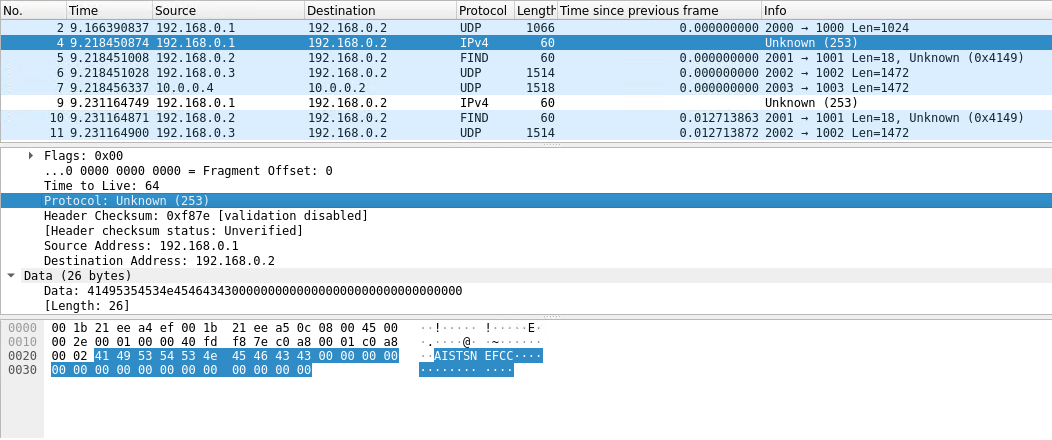

In [22]:
display(Image(filename='img/1_wireshark_frameinfo1.png', embed=True))

### frame2
This frame is the same as frame 0 except that the IP address, source and destination port numbers and frame size are different.

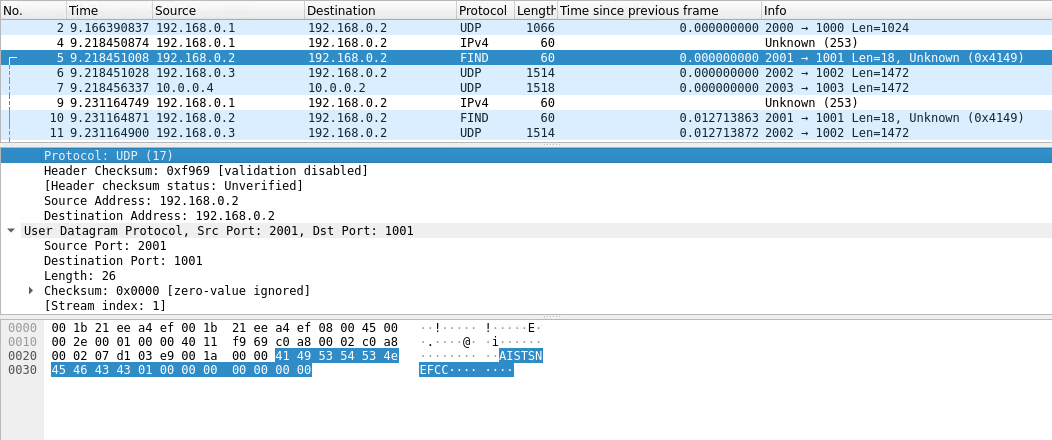

In [23]:
display(Image(filename='img/1_wireshark_frameinfo2.png', embed=True))

### frame3
This frame is the same as frame 0 except for the IP address, source, destination port number and frame size.

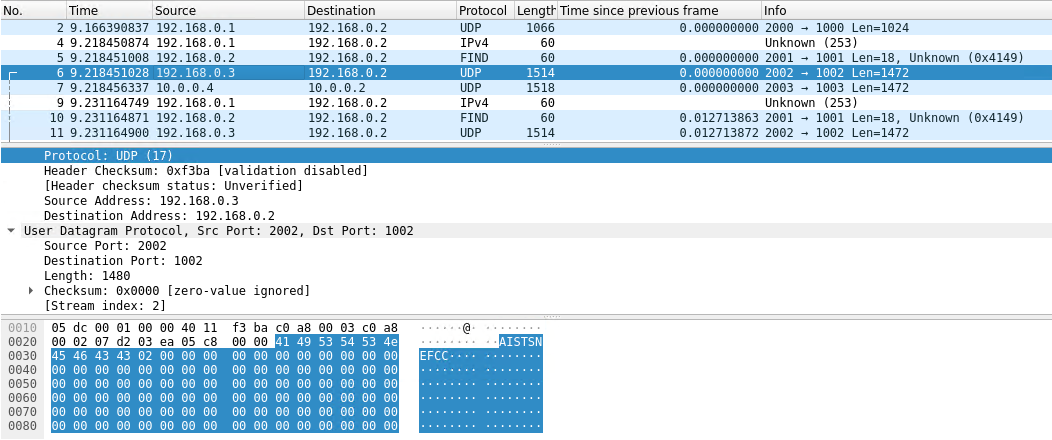

In [24]:
display(Image(filename='img/1_wireshark_frameinfo3.png', embed=True))

### frame4
This frame has the same payload size as frame 3, but the frame size is larger due to the VLAN TAG.  
VLAN TAG is inserted between ethernet header and ipv4 header.  
You can see that the VLAN ID and PCP (PRI) are as set.  
The start position of the payload is 4 bytes later than frame 3 due to the increase in the VLAN TAG.

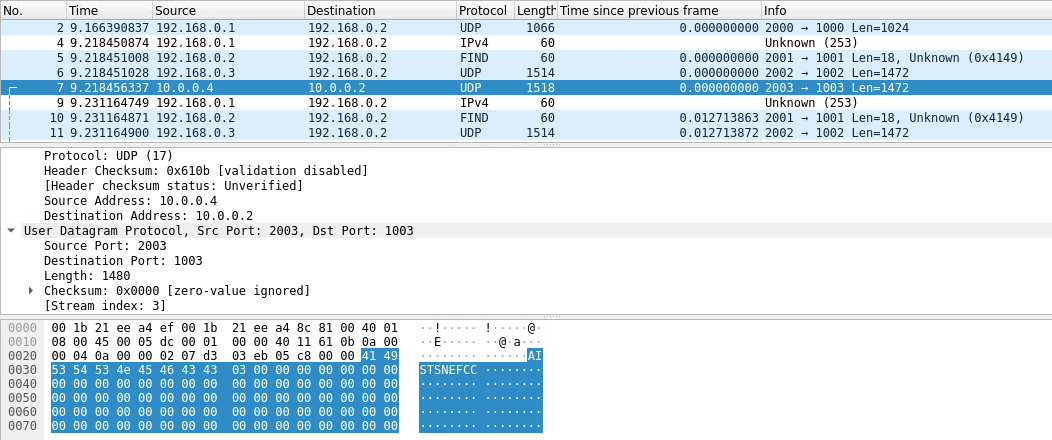

In [25]:
display(Image(filename='img/1_wireshark_frameinfo4.png', embed=True))

## 2. Sending frames with repeats
Next, we send frames in repeat mode.  
Repeat mode means that ef_crafter automatically restart after stopping.

### 2-A. Running the frame crafter with repeat enabled
By calling crafter.set_repeat() before calling crafter.start(), you can enable repeat transmission.

In [26]:
port0 = 0
bit_mask = (1 << port0)
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)

### 2-B. Wait for the specified number of frames to be transmitted
Wait until 1000 frames are sent

In [27]:
crafter.wait_until(port0, 1000)

1000 frames are sent. Since the frame crafter is still sending frame, the counter value is larger than 1000. Current status is 

In [28]:
print('-------')
print('Port0:')
for k, v in crafter.get_status(0).items():
    print(f'  {k}: {v}')
print('-------')

-------
Port0:
  status: Sending frames
  repeat: enable
  loopcounter: 685
  framecounter: 2641
  com_running: True
  com_repeat: True
  com_fno_reset: True
  sta_send_done: True
  sta_repeat_done: True
  sta_counter_reset_done: True
-------


### 2-C. Stop the frame crafter
When repeat mode is enabled, the frame crafter does not stop automatically and must be stopped by resetting.

In [29]:
crafter.reset(0xff)

## 3. Control of the transmission rate of the frame crafter
The frame crafter transmits frames with a minimum frame transmission interval.
There are two ways to increase the frame transmission interval and control the transmission rate, which can also be used in combination.
- Set await on frames
- Adding NOP frames

If you are connecting the TSN-EFCC to a NIC, start WireShark from here to start the frame capture process.
```shell
$ sudo wireshark
```

### 3-A. Transmission of frames at minimum frame intervals
For comparison, generate a normal and send about 1000 frames.

In [30]:
import time

crafter.set_frame(port=0, index=0, frame=frame0.clone().payload(100))
crafter.set_frame(port=0, index=1, frame=eol_frame)

port0 = 0
bit_mask = (1 << port0)
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)

# wait 0.5 sec
time.sleep(0.5)

print('Reset frame crafter to stop repeating.')
crafter.reset(0xff)

# wait 0.5 sec
time.sleep(0.5)

Reset frame crafter to stop repeating.


### 3-B. Transmission of frames using await
Next, we will send a frame of the same size as before, but with await (additional wait) set.  
await is a function that increases the frame transmission interval by 0 to 127 cycles.  
The advantages of await over NOP frames, described below, are that it can create frame intervals smaller than 84 cycles and it does not consume frame crafter entries.

In [31]:
crafter.set_frame(port=0, index=0, frame=frame0.clone().payload(100).additional_wait(127))
crafter.set_frame(port=0, index=1, frame=eol_frame)

print('Dump the frame information pushed to ef_crafter.')

print('-------')
for frame in crafter.get_frames(port=0):
    print(frame)
print('-------')

port0 = 0
bit_mask = (1 << port0)
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)

# wait 0.5 sec
time.sleep(0.5)

print('Reset frame crafter to stop repeating.')
crafter.reset(0xff)

# wait 0.5 sec
time.sleep(0.5)

Dump the frame information pushed to ef_crafter.
-------
Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=100).AdditionalWait(127)
EOL()
-------
Reset frame crafter to stop repeating.


### 3-C. Transmission of frames with NOP frames in between
If you specify NOP when generating frames, the frame crafter will stop sending for the duration of the NOP frame.  
NOP frames can create larger frame intervals than await, but they consume a frame crafter entry, so the number of entries available for normal frames is reduced by the number of NOP frames.

Except that they are not actually transmitted, NOP frames are treated in the same way as normal frames, so the minimum size of an NOP frame, including the FCS, is 64 bytes.  
Therefore, the additional interframe spacing caused by inserting a single NOP frame is 84 cycles, i.e. 84 bytes, including the 20 bytes of preamble and interframe gap.  
The payload size of the NOP frame can be specified up to 0xFFFF (65535) bytes. It is also possible to add await to a NOP frame.  
If you want to have a frame interval longer than what can be obtained with a NOP frame + await, it is possible to insert multiple NOP frames to create the desired frame interval.

In [32]:
print('If you alternate normal frames and NOP frames of the same size, the transmission rate will be halved.')

crafter.set_frame(port=0, index=0, frame=frame0.clone().payload(100))
crafter.set_frame(port=0, index=1, frame=frame0.clone().payload(100).nop())
crafter.set_frame(port=0, index=2, frame=eol_frame)

print('Dump the frame information pushed to ef_crafter.')

print('-------')
for frame in crafter.get_frames(port=0):
    print(frame)
print('-------')

print('Send these frames from ef_crafter.')
port = 0
bit_mask = 1 << port
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)

# wait 0.5 sec
time.sleep(0.5)

print('Reset frame crafter to stop repeating.')
crafter.reset(0xff)

# wait 0.5 sec
time.sleep(0.5)

If you alternate normal frames and NOP frames of the same size, the transmission rate will be halved.
Dump the frame information pushed to ef_crafter.
-------
Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=100)
Frame0001.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=100).Nop()
EOL()
-------
Send these frames from ef_crafter.
Reset frame crafter to stop repeating.


In [33]:
print('If you send two NOP frames of the same size after a normal frame, the transmission speed is reduced to 1/3.')

crafter.set_frame(port=0, index=0, frame=frame0.clone().payload(100))
crafter.set_frame(port=0, index=1, frame=frame0.clone().payload(100).nop())
crafter.set_frame(port=0, index=2, frame=frame0.clone().payload(100).nop())
crafter.set_frame(port=0, index=3, frame=eol_frame)

print('Dump the frame information pushed to ef_crafter.')

print('-------')
for frame in crafter.get_frames(port=0):
    print(frame)
print('-------')

print('Send these frames from ef_crafter.')
port = 0
bit_mask = 1 << port
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)

# wait 0.5 sec
time.sleep(0.5)

print('Reset frame crafter to stop repeating.')
crafter.reset(0xff)

If you send two NOP frames of the same size after a normal frame, the transmission speed is reduced to 1/3.
Dump the frame information pushed to ef_crafter.
-------
Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=100)
Frame0001.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=100).Nop()
Frame0002.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=1000, src=2000).Payload(length=100).Nop()
EOL()
-------
Send these frames from ef_crafter.
Reset frame crafter to stop repeating.


The payload size is the same for all four frame transfer methods so far, but the frame interval is different.  
When the receive rate at the NIC is plotted using WireShark's I/O Graphs function, it looks like this.  
Compared to the first transmission at the minimum interval, it can be seen that the transmission rate has decreased for transmissions using Wait and NOP.

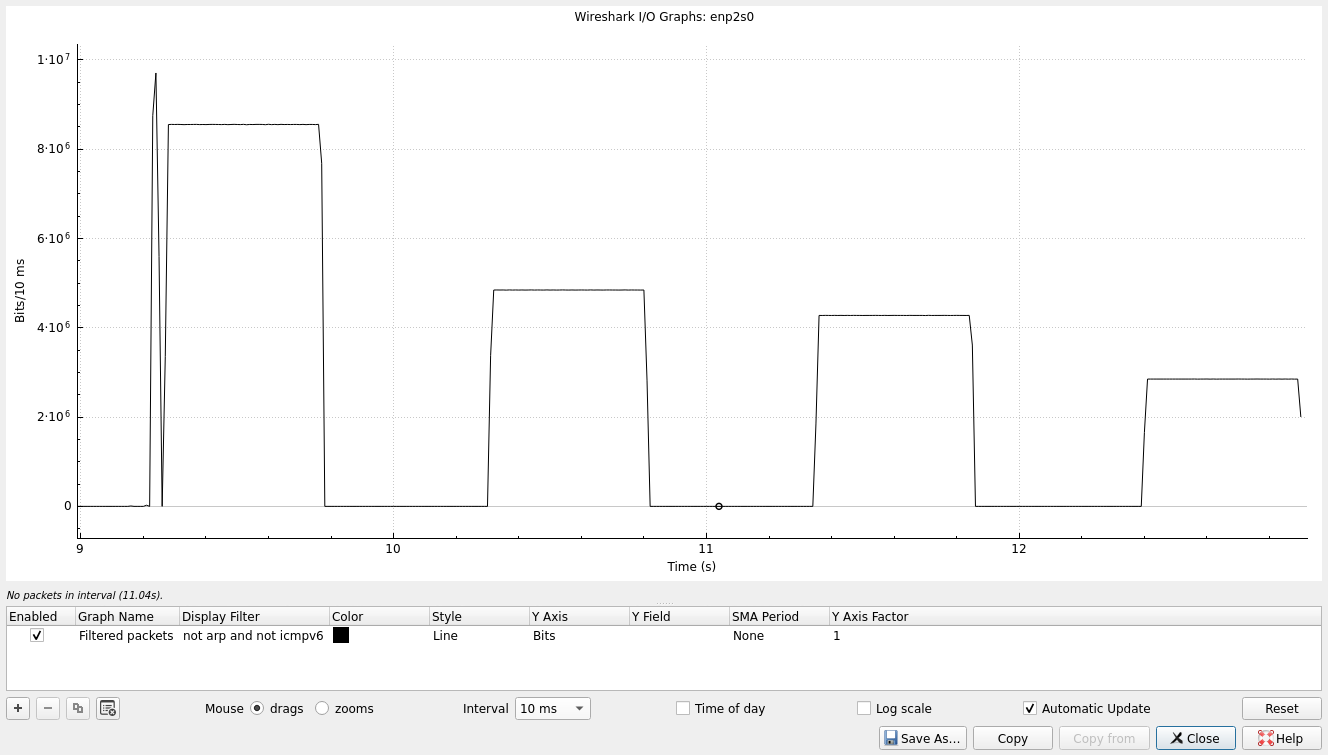

In [34]:
display(Image(filename='img/1_wireshark_iograph.png', embed=True))